# REINFORCE

In this notebook, we will implement REINFORCE algorithm for Cart Pole Environment.

**Mountain Car MDP**


The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reinforce

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

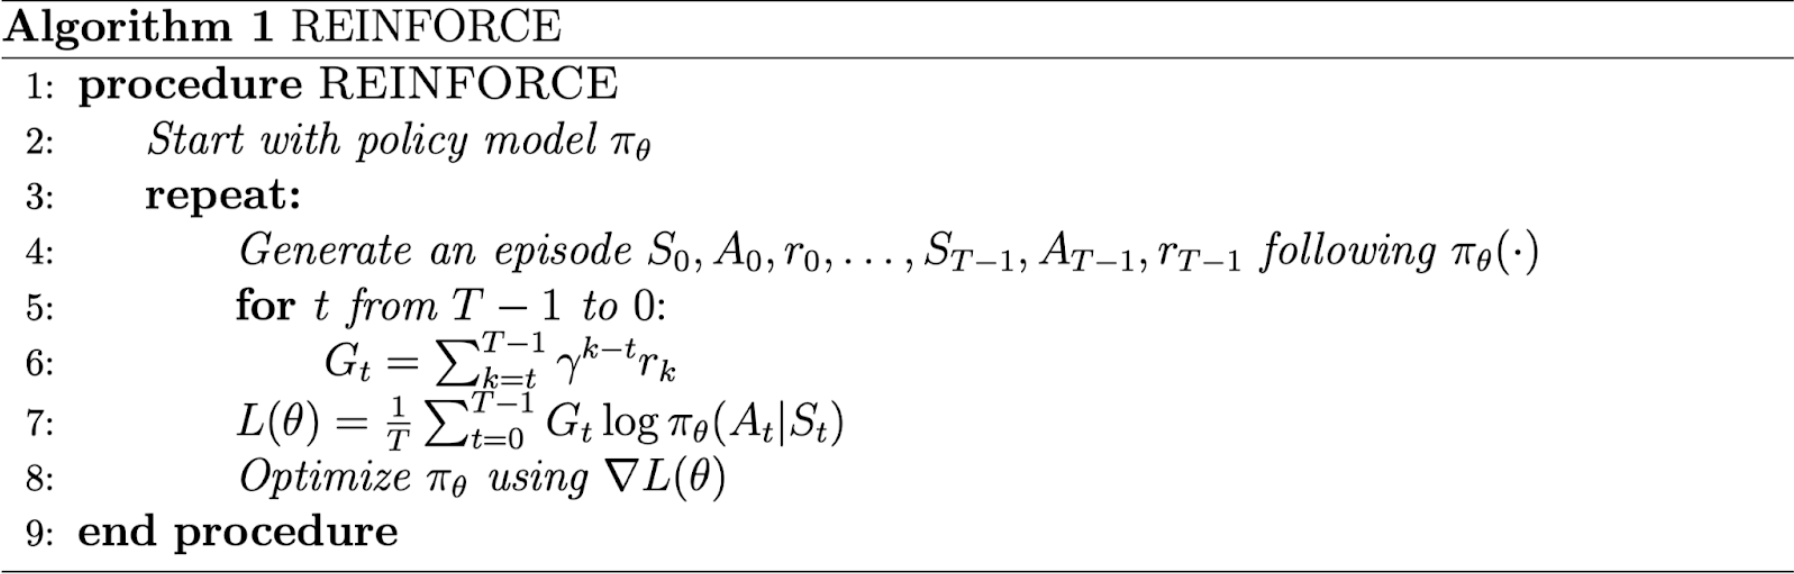




### Hints
- Try to use at least a 3 to 4 layer network with tanh activation at last layer.
- Use high value of gamma and max_steps
- Try to understand the reward function and think how the agent can get stuck in a non-optimal reward trajectory.

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Normal

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Policy Network

In [80]:
# A neural network for policy
# It takes the state as input and predicts the probability of each action
class Policy(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128,256)
        self.layer3 = nn.Linear(256,64)
        self.mu = nn.Linear(64, n_actions)
        self.log_std = nn.Parameter(torch.zeros(n_actions)*1.0,requires_grad=True)


    def forward(self, x):
        x = F.leaky_relu(self.layer1(x))
        x = F.leaky_relu(self.layer2(x))
        x = F.leaky_relu(self.layer3(x))
        return self.mu(x)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        mu = self.forward(state)
        sigma = torch.exp(self.log_std)
        m = Normal(mu,sigma)
        action = m.sample()
        return action.item(), m.log_prob(action)

### Hyperparameters

In [122]:

total_episodes = 100     
max_steps = 500            
learning_rate = 1e-3        
gamma = 0.99               

### Training

In [123]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box(-1.0, 1.0, (1,), float32)
state size: 2
action size: 1


In [124]:

policy_net = Policy(state_size, action_size).to(device)

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [160]:
def height(x):
  return np.abs(x+0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
def getrew(state):
  if state[1]<0.01:
    if height(state[0])<0.3:
      return -1
  if height(state[0])>=0.5:
    return 2
  else:
    return (height(state[0])+1.2)/1.8

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [181]:
scores = []
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  maxheight = 0
  done = False
  while not done:
    action, log_prob = policy_net.act(state)
    saved_log_probs.append(log_prob)
    state, reward, done, _ = env.step([action])
    if np.abs(state[0]+0.5)<0.01:
      reward += 100*max(np.abs(state[1])-maxheight,0)
      maxheigt = max(np.abs(state[1]),maxheight)
    if state[0]>0.55:
      reward = 10000
    rewards.append(reward)
    if done:
        break


  scores.append(sum(rewards))

  returns = deque(maxlen=max_steps)
  n_steps = len(rewards)


  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( gamma*disc_return_t + rewards[t]   )
  eps = np.finfo(np.float32).eps.item()
  returns = torch.tensor(returns)
  returns = (returns - returns.mean()) / (returns.std() + eps)

  policy_loss = []
  for log_prob, disc_return in zip(saved_log_probs, returns):
    policy_loss.append(-log_prob * disc_return)
  policy_loss = torch.cat(policy_loss).sum()

  optimizer.zero_grad()
  policy_loss.backward()
  optimizer.step()

  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = -0.10399663298665465
Episode 2: Reward = 7.256233099361286
Episode 3: Reward = 9.988900645644856
Episode 4: Reward = 9.561665982293
Episode 5: Reward = 4.4851030663600095
Episode 6: Reward = -7.568919665921043
Episode 7: Reward = -6.896977990645532
Episode 8: Reward = -2.5206104326851566
Episode 9: Reward = 0.9599997229850724
Episode 10: Reward = -8.15093361098954
Episode 11: Reward = -18.845078979080714
Episode 12: Reward = 3.905452672374033
Episode 13: Reward = 6.779606385861987
Episode 14: Reward = 3.423093241322015
Episode 15: Reward = 1.6624508904283333
Episode 16: Reward = -1.753640386271155
Episode 17: Reward = 5.4447982794194045
Episode 18: Reward = 7.783209600637549
Episode 19: Reward = 5.840416152251659
Episode 20: Reward = -4.30576116621691
Episode 21: Reward = -6.329560068164941
Episode 22: Reward = 5.813361410097456
Episode 23: Reward = 4.0180229232003475
Episode 24: Reward = -0.7360776910112955
Episode 25: Reward = 12.347735325839361
Episode 26: Reward

Text(0, 0.5, 'Reward')

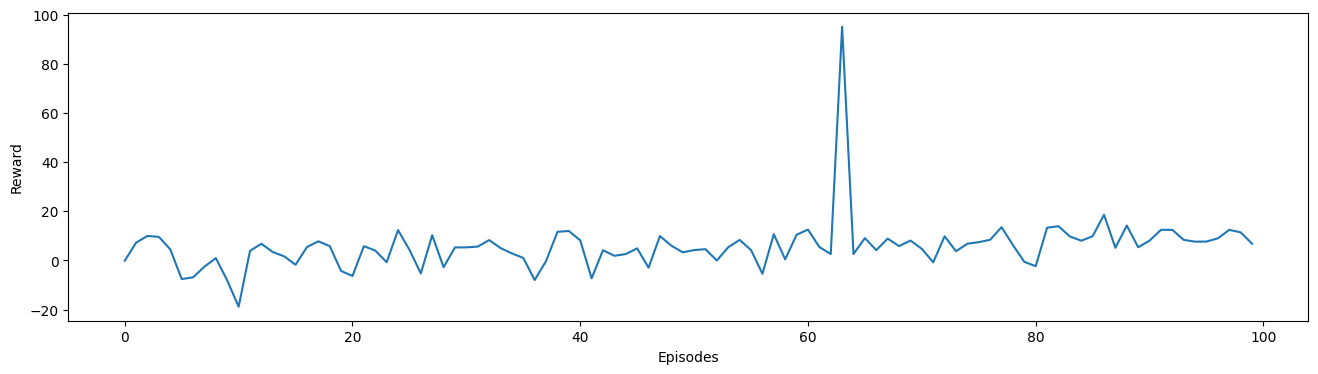

In [182]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [183]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [184]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _ = policy_net.act(state)
        next_state, reward, done, info = env.step([action])
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [185]:
show_video_of_model('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [186]:

show_video('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
